In [8]:
import json
import glob
import os
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs, class_balance
from epilepsypcm.utils.outcome_params import engel_score


from sklearn import datasets
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [9]:
#Location
base_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/' #modify for your file location

#Function to get the concatenated dataframe for all positive patients
all_positive_patients = concat_dfs(base_path, "1")

In [10]:
def randomForest(df,keys,balance_=None):
    X = df[keys]
    y = df.outcome
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    X_train, y_train = class_balance(X_train, y_train, balance = balance_)
    
    rfc=RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train,y_train)
    y_pred=rfc.predict(X_test)
    
    #create feature importance object
    feature_imp = pd.Series(rfc.feature_importances_,index=keys).sort_values(ascending=False)
    #print(feature_imp)
    #plot the feature importance
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.savefig('RF Feature Importance.png')
    plt.show()
   
    #plot the ROC curve
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0,1],[0,1],label='No Model')
    plt.title('ROC Curve: Random Forest Model')
    plt.legend()
    plt.savefig('RF ROC Curve.png')
    plt.show()
   
    
    #plot the Precision-Recall curve
    ax = plt.gca()
    rfc_disp = PrecisionRecallDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
    baseline = len(y_test[y_test==1])/len(y_test)
    plt.plot([0,1],[baseline,baseline],label='No Model (AP=%f)'%(int(baseline*100)/100))
    plt.title('Precision Recall Curve: Random Forest Model')
    plt.legend()
    plt.savefig('RF Precision-Recall Curve.png')
    plt.show()
    
    AUC = metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])
    AP = metrics.average_precision_score(y_test, rfc.predict_proba(X_test)[:,1])
    
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print('AUC_ROC = %f'%(AUC))
    print('AP_PR =%f'%(AP))
    
    return metrics.accuracy_score(y_test, y_pred), AUC, AP, rfc.feature_importances_
    

In [11]:
A = all_positive_patients
A.n1Zscore = A.n1Zscore.abs()
A.n2Zscore = A.n2Zscore.abs()
A.p2Zscore = A.p2Zscore.abs()
A

,chNames,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,flipped,outcome
2,LA3_LA4,0.0,1.396644,1.062212,5.025081,13.0,180.0,43.0,1.0,1.0
6,LA7_LA8,0.0,1.371992,1.735958,0.305671,17.0,131.0,47.0,1.0,0.0
7,LA8_LA9,0.0,1.990935,0.596185,0.596185,19.0,101.0,101.0,1.0,0.0
10,LAH2_LAH3,0.0,4.324042,4.524443,1.176967,16.0,101.0,45.0,1.0,1.0
11,LAH3_LAH4,0.0,4.214433,2.351241,1.154445,15.0,110.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,0.0,0.775927,2.579947,4.290270,51.0,285.0,195.0,0.0,0.0
707,RPFS7_RPFS8,0.0,1.769931,5.228859,3.093837,12.0,139.0,69.0,1.0,0.0
708,RPFI1_RPFI2,0.0,1.361718,2.097774,1.999799,14.0,338.0,278.0,1.0,0.0
709,RPFI2_RPFI3,0.0,2.863802,2.631576,7.996893,44.0,228.0,118.0,0.0,0.0


Index(['n1Zscore', 'n2Zscore', 'p2Zscore', 'n1Latency', 'n2Latency',
       'p2Latency'],
      dtype='object')


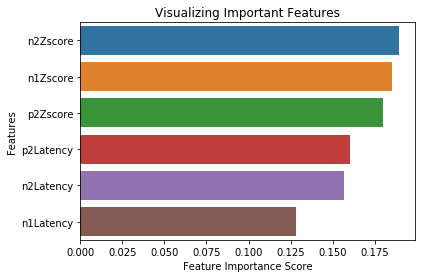

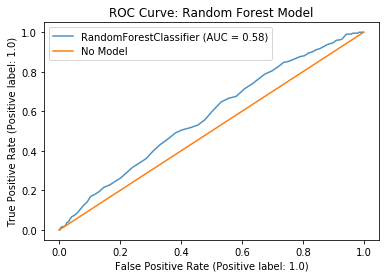

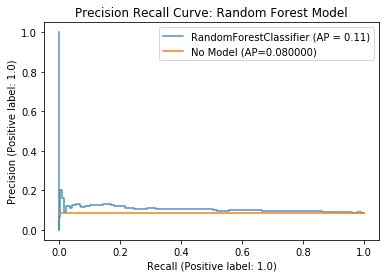

Accuracy: 0.5439459127228027
AUC_ROC = 0.575812
AP_PR =0.105597


,chNames,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,flipped,outcome
2,LA3_LA4,0.0,1.396644,1.062212,5.025081,13.0,180.0,43.0,1.0,1.0
6,LA7_LA8,0.0,1.371992,1.735958,0.305671,17.0,131.0,47.0,1.0,0.0
7,LA8_LA9,0.0,1.990935,0.596185,0.596185,19.0,101.0,101.0,1.0,0.0
10,LAH2_LAH3,0.0,4.324042,4.524443,1.176967,16.0,101.0,45.0,1.0,1.0
11,LAH3_LAH4,0.0,4.214433,2.351241,1.154445,15.0,110.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,0.0,0.775927,2.579947,4.290270,51.0,285.0,195.0,0.0,0.0
707,RPFS7_RPFS8,0.0,1.769931,5.228859,3.093837,12.0,139.0,69.0,1.0,0.0
708,RPFI1_RPFI2,0.0,1.361718,2.097774,1.999799,14.0,338.0,278.0,1.0,0.0
709,RPFI2_RPFI3,0.0,2.863802,2.631576,7.996893,44.0,228.0,118.0,0.0,0.0


In [30]:
keys = all_positive_patients.keys()
print(keys[2:8])
A = all_positive_patients
A.n1Zscore = A.n1Zscore.abs()
A.n2Zscore = A.n2Zscore.abs()
A.p2Zscore = A.p2Zscore.abs()
randomForest(A,keys[2:8],'downsample')
A

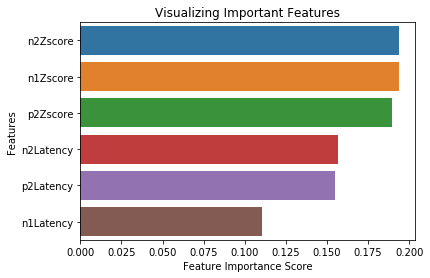

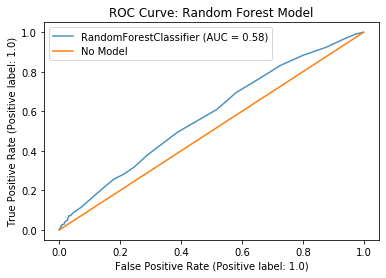

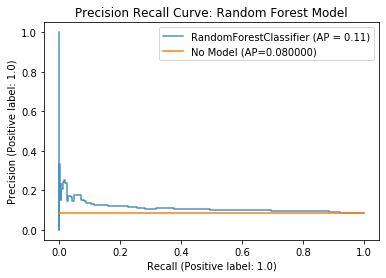

Accuracy: 0.9143618111042819
AUC_ROC = 0.577320
AP_PR =0.111568


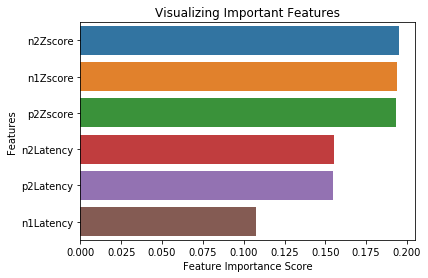

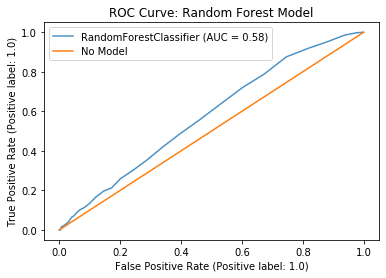

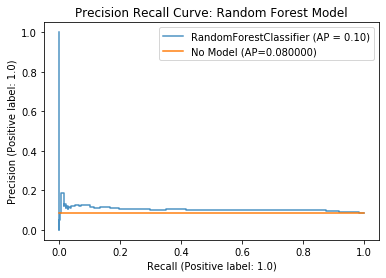

Accuracy: 0.9141569350542922
AUC_ROC = 0.577709
AP_PR =0.104332


KeyboardInterrupt: 

In [29]:
keys = all_positive_patients.keys()

Acc = []
AUC = []
AP = []
FI =np.array([0,0,0,0,0,0])

for i in range(50):
    Acc_, AUC_, AP_, FI_ = randomForest(all_positive_patients,keys[2:8])
    Acc.append(Acc_)
    AP.append(AP_)
    AUC.append(AUC_)
    FI = FI + np.array(FI_) 

AUC_ROC = 0.577499
AP_PR =0.107409
Accuracy: 0.9143863962302808


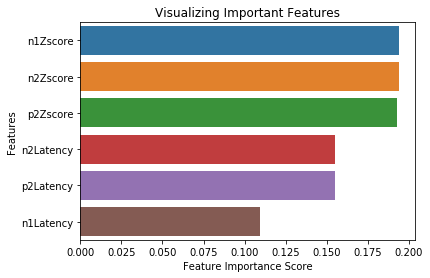

In [58]:
print('AUC_ROC = %f'%(sum(AUC)/len(AUC)))
print('AP_PR =%f'%(sum(AP)/len(AP)))
print("Accuracy:",sum(Acc)/len(Acc))
feature_imp = pd.Series(FI/50,index=keys[2:8]).sort_values(ascending=False)
#print(feature_imp)
#plot the feature importance
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('RF Feature Importance.png')
plt.show()

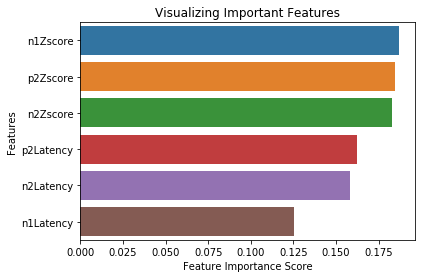

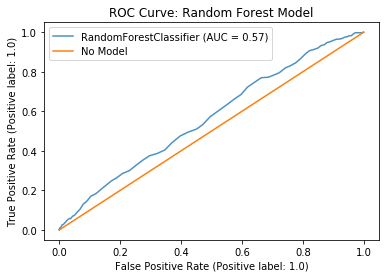

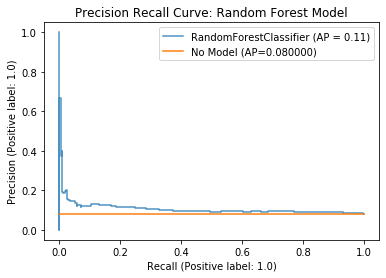

Accuracy: 0.5457897971727105
AUC_ROC = 0.567306
AP_PR =0.106799


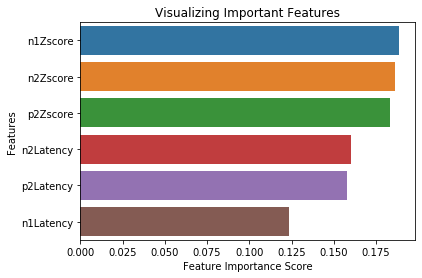

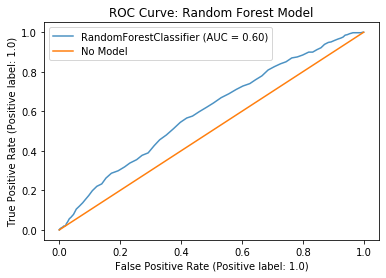

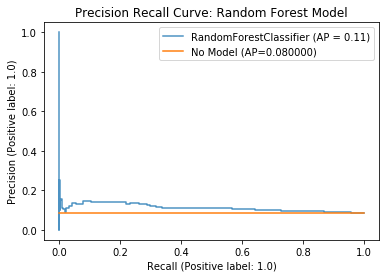

Accuracy: 0.5634091374718295
AUC_ROC = 0.597117
AP_PR =0.112568


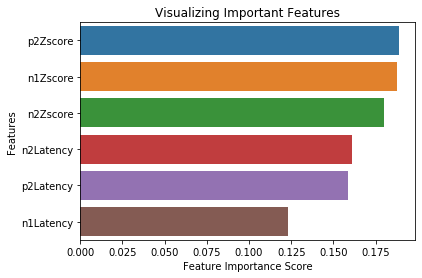

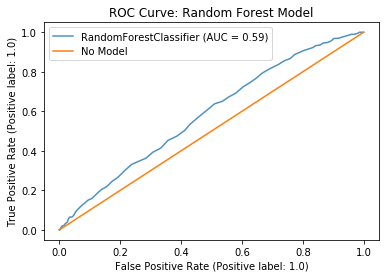

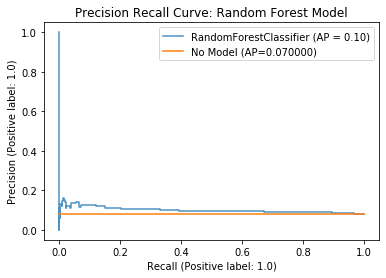

Accuracy: 0.545380045072731
AUC_ROC = 0.585067
AP_PR =0.100899


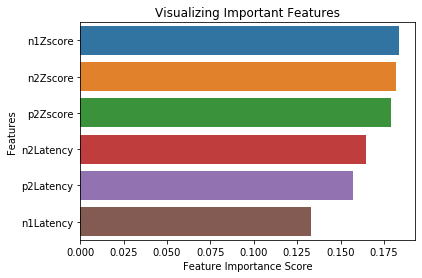

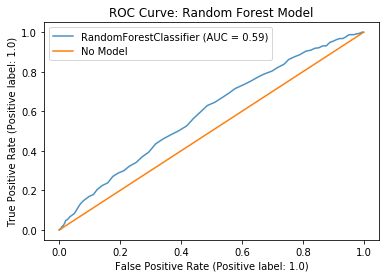

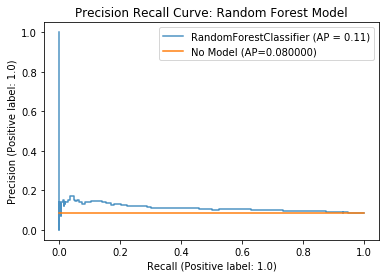

Accuracy: 0.5589018643720549
AUC_ROC = 0.591703
AP_PR =0.111144


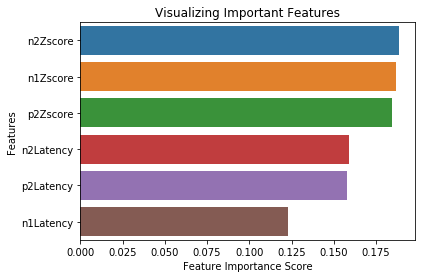

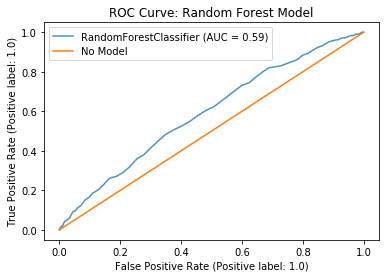

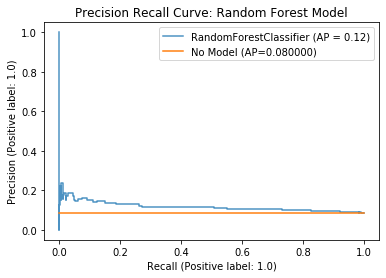

Accuracy: 0.5464044253226797
AUC_ROC = 0.591604
AP_PR =0.117355


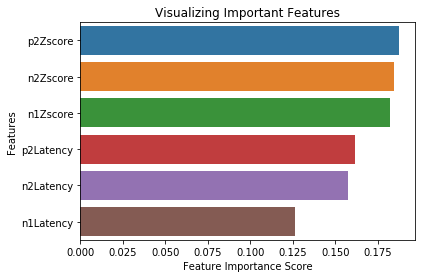

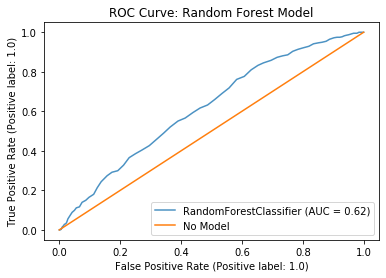

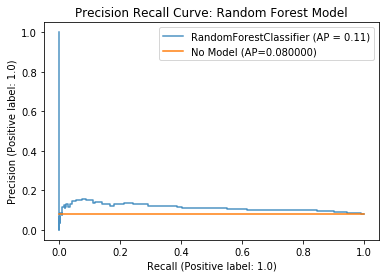

Accuracy: 0.5437410366728129
AUC_ROC = 0.618046
AP_PR =0.113223


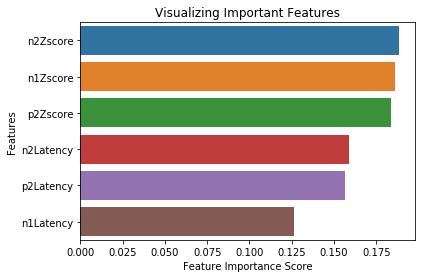

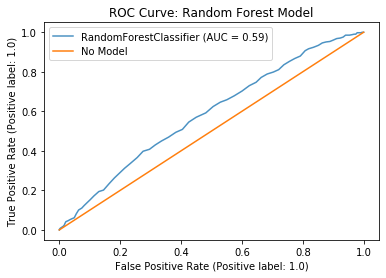

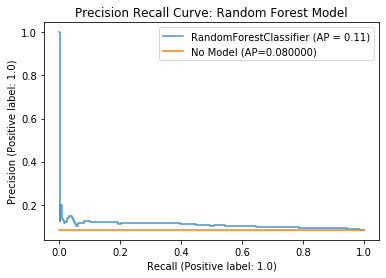

Accuracy: 0.5722188076213891
AUC_ROC = 0.585138
AP_PR =0.108918


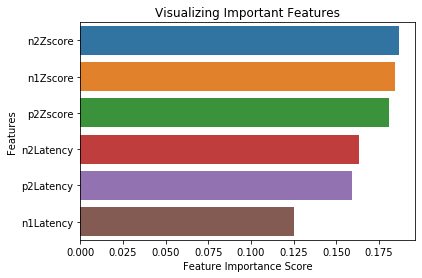

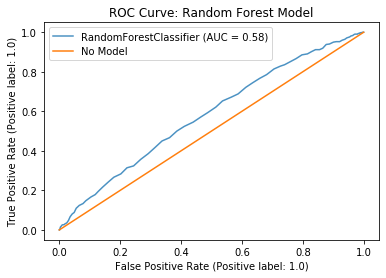

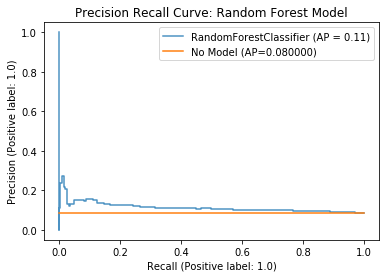

Accuracy: 0.5380045072730998
AUC_ROC = 0.581695
AP_PR =0.113282


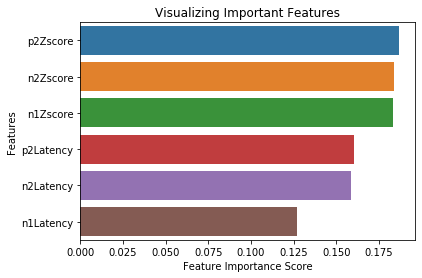

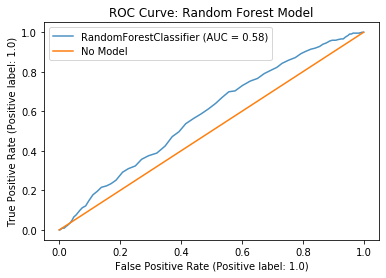

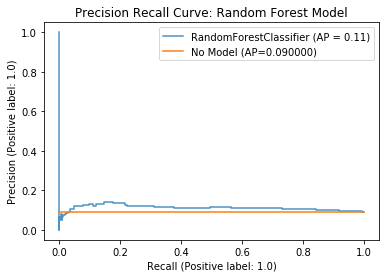

Accuracy: 0.5392337635730383
AUC_ROC = 0.583818
AP_PR =0.112085


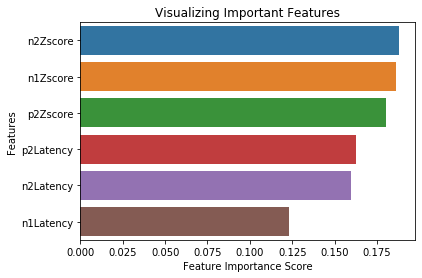

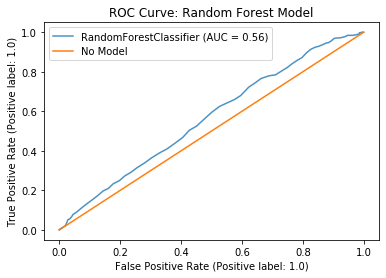

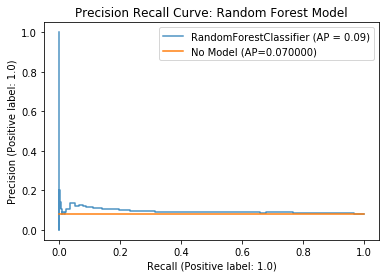

Accuracy: 0.5472239295226388
AUC_ROC = 0.564083
AP_PR =0.094210


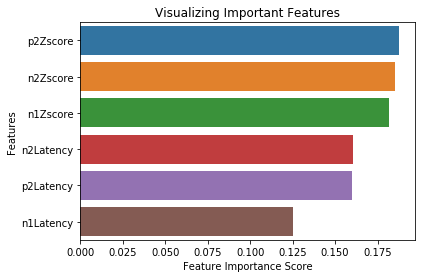

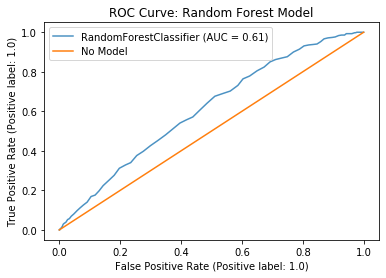

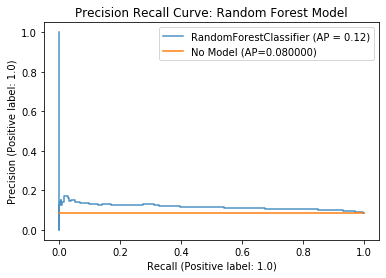

Accuracy: 0.562179881171891
AUC_ROC = 0.609074
AP_PR =0.116392


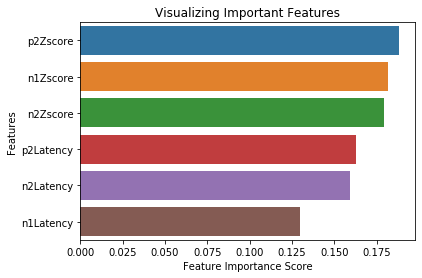

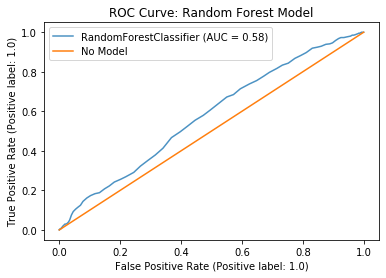

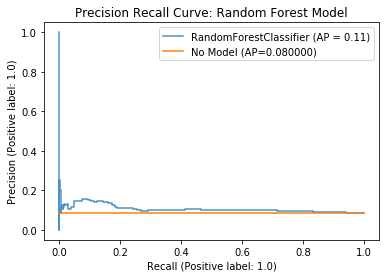

Accuracy: 0.553779963122311
AUC_ROC = 0.576626
AP_PR =0.106312


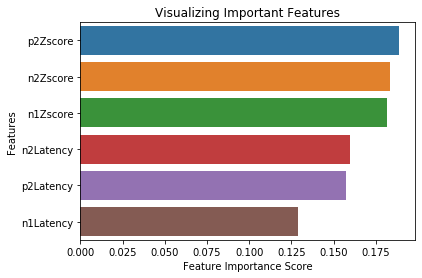

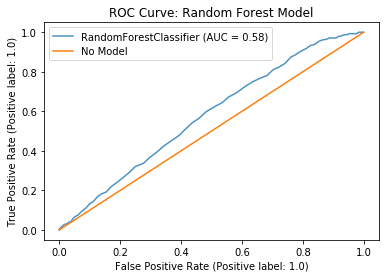

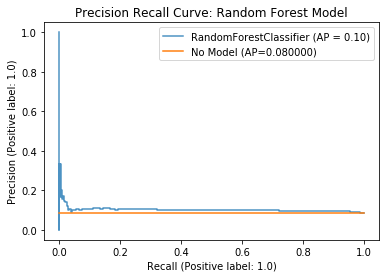

Accuracy: 0.5423069043228846
AUC_ROC = 0.576783
AP_PR =0.103133


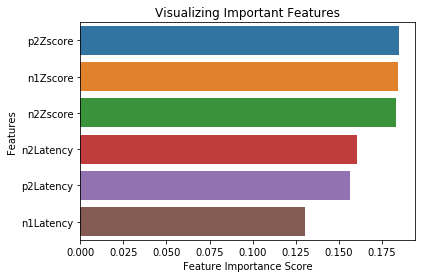

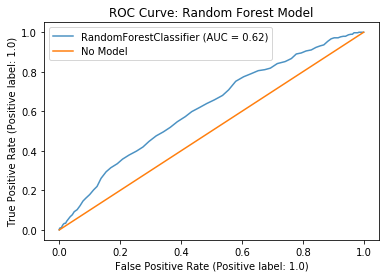

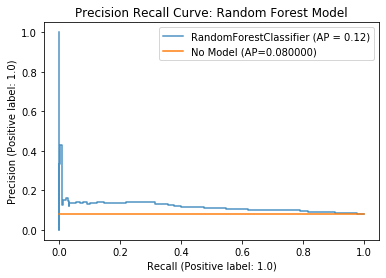

Accuracy: 0.5675066584716246
AUC_ROC = 0.616117
AP_PR =0.117196


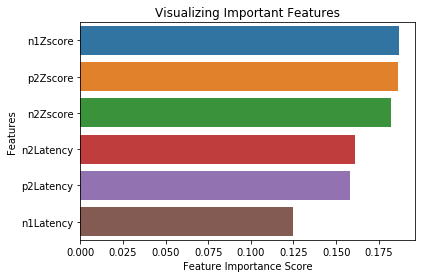

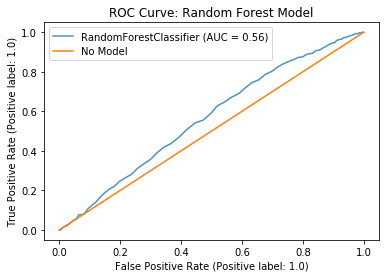

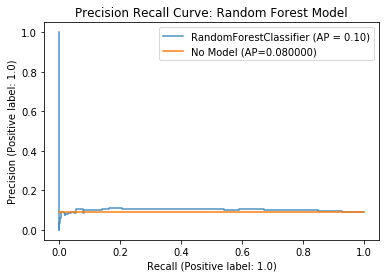

Accuracy: 0.5519360786724032
AUC_ROC = 0.564287
AP_PR =0.101128


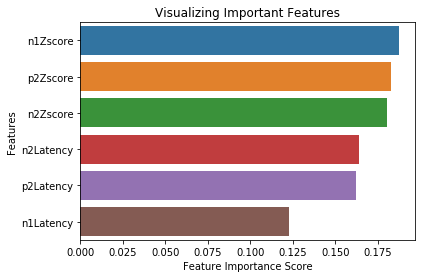

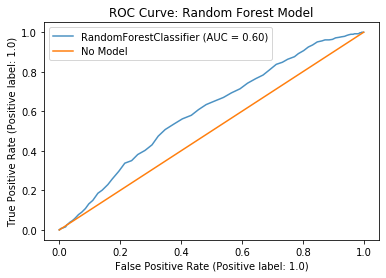

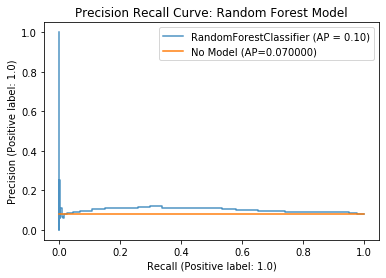

Accuracy: 0.5673017824216349
AUC_ROC = 0.599191
AP_PR =0.101636


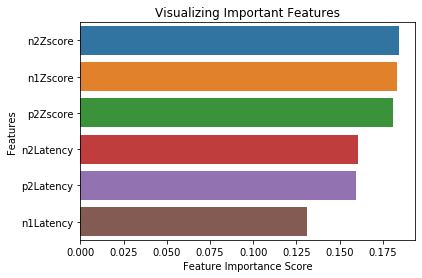

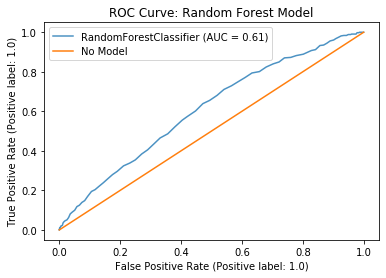

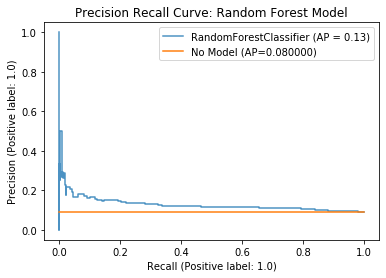

Accuracy: 0.5566482278221676
AUC_ROC = 0.608817
AP_PR =0.128687


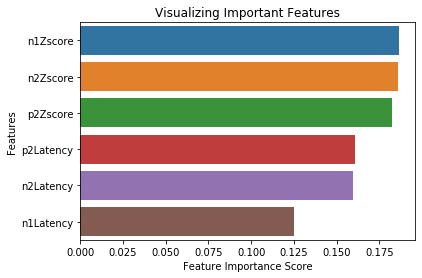

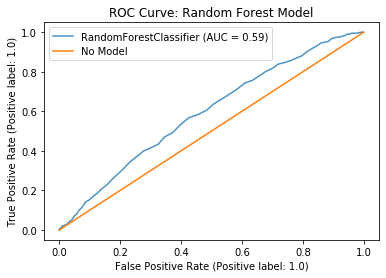

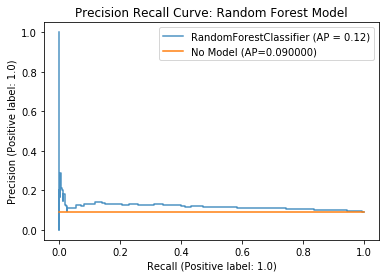

Accuracy: 0.5736529399713174
AUC_ROC = 0.593538
AP_PR =0.117991


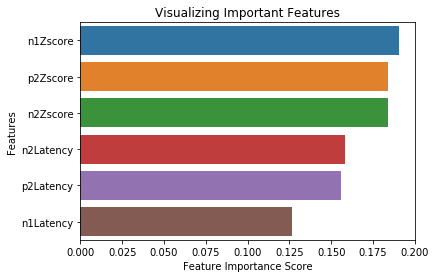

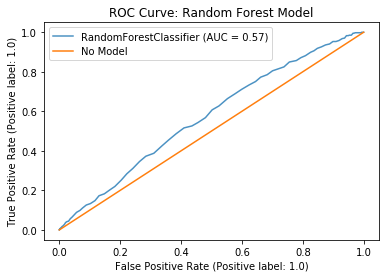

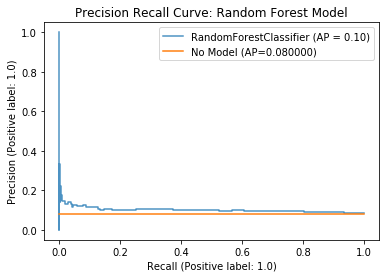

Accuracy: 0.5443556648227822
AUC_ROC = 0.571937
AP_PR =0.102235


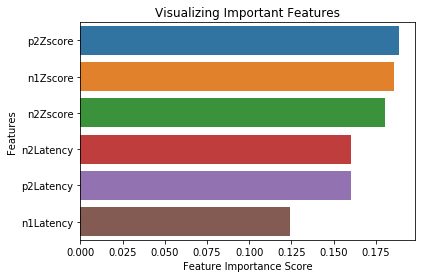

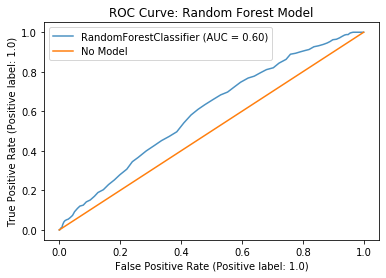

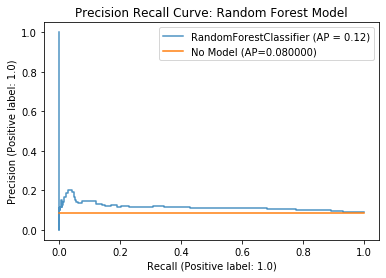

Accuracy: 0.5498873181725056
AUC_ROC = 0.598781
AP_PR =0.115458


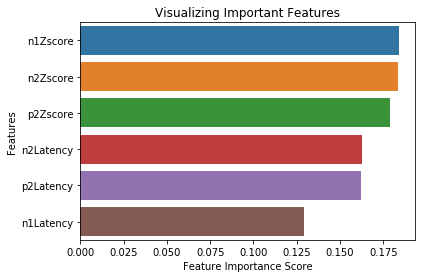

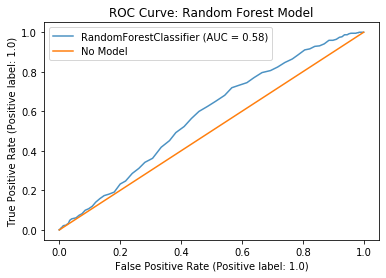

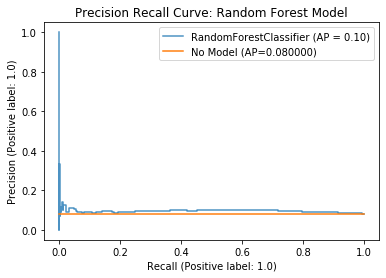

Accuracy: 0.5656627740217168
AUC_ROC = 0.578288
AP_PR =0.096104


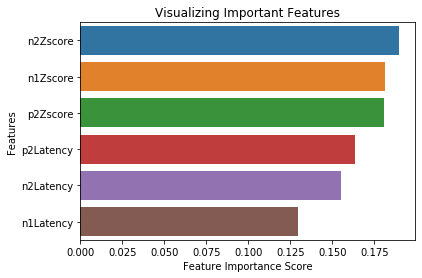

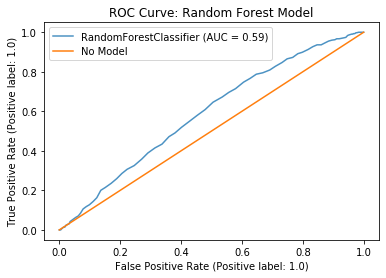

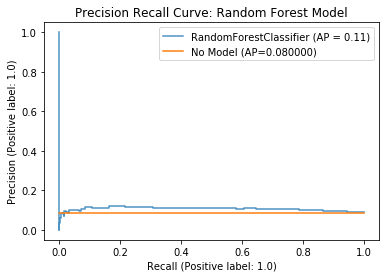

Accuracy: 0.5492726900225363
AUC_ROC = 0.588409
AP_PR =0.106304


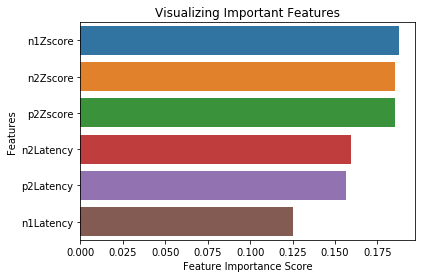

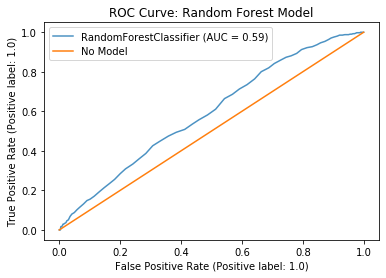

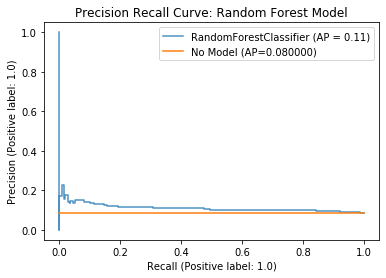

Accuracy: 0.5425117803728744
AUC_ROC = 0.590581
AP_PR =0.110924


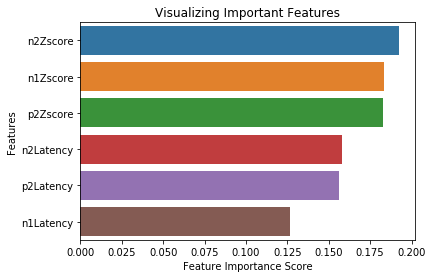

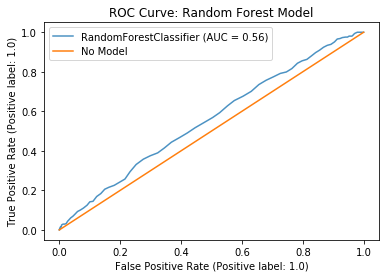

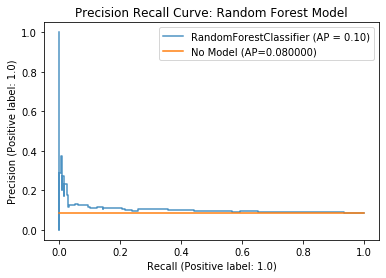

Accuracy: 0.550501946322475
AUC_ROC = 0.556850
AP_PR =0.103475


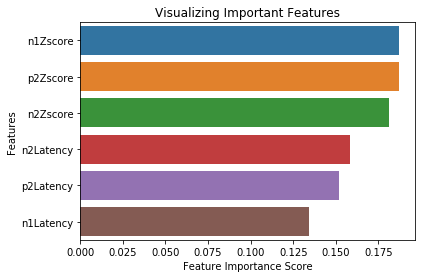

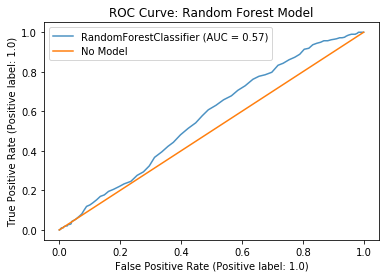

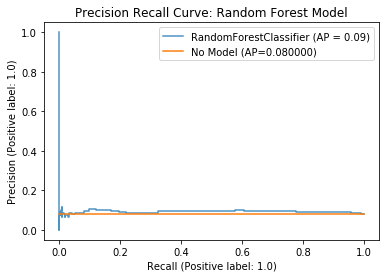

Accuracy: 0.5509116984224545
AUC_ROC = 0.567863
AP_PR =0.092786


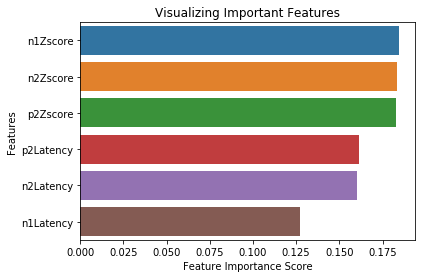

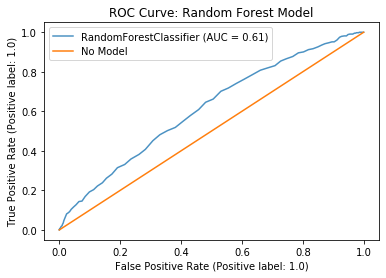

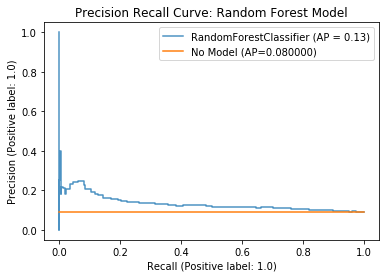

Accuracy: 0.5480434337225978
AUC_ROC = 0.612208
AP_PR =0.132797


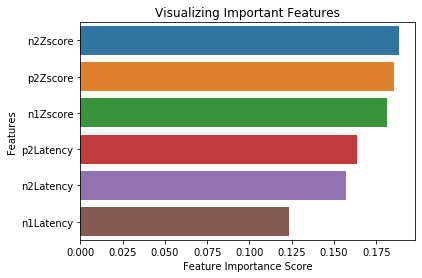

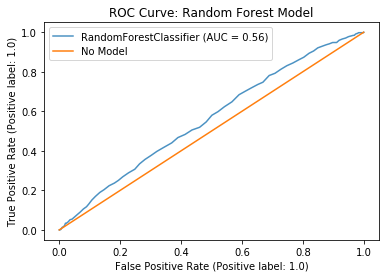

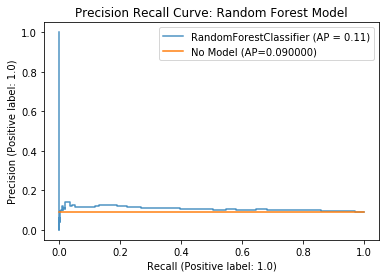

Accuracy: 0.5586969883220652
AUC_ROC = 0.561843
AP_PR =0.107339


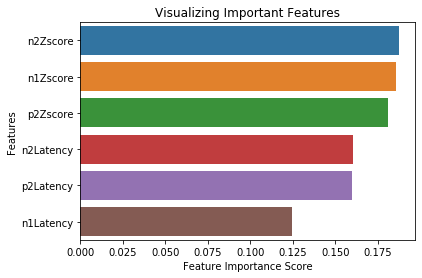

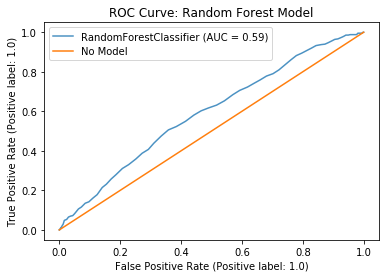

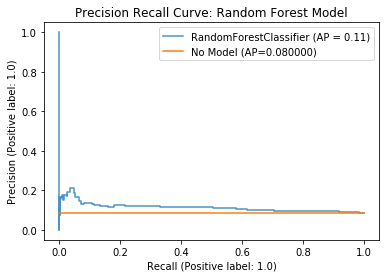

Accuracy: 0.5599262446220037
AUC_ROC = 0.591098
AP_PR =0.113828


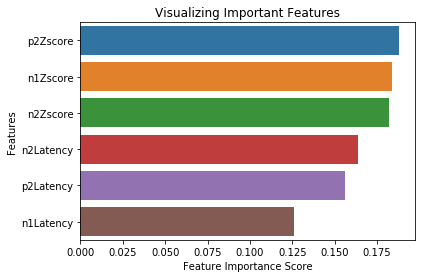

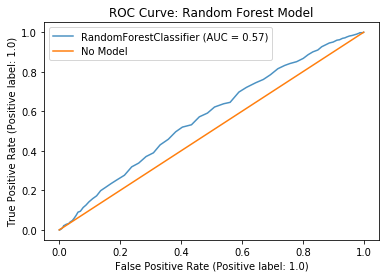

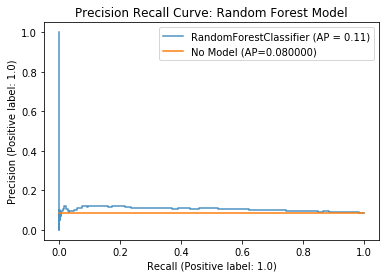

Accuracy: 0.589018643720549
AUC_ROC = 0.573372
AP_PR =0.105005


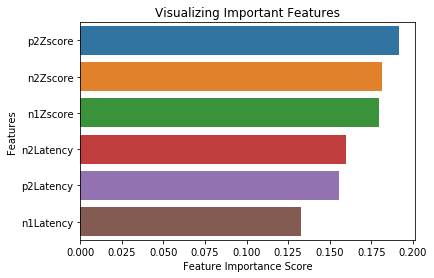

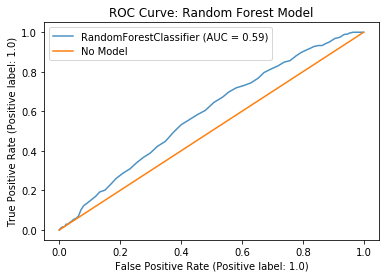

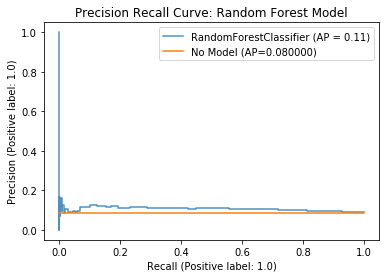

Accuracy: 0.5498873181725056
AUC_ROC = 0.587667
AP_PR =0.106272


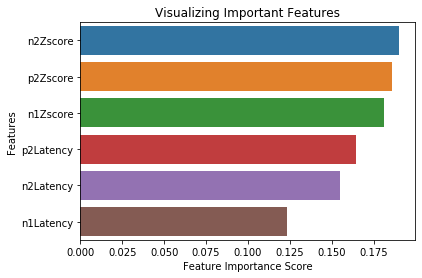

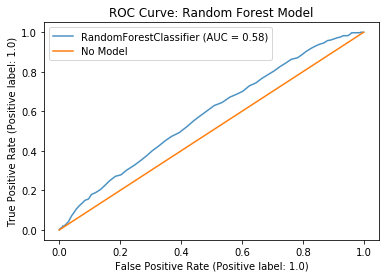

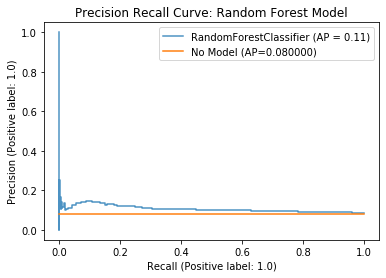

Accuracy: 0.5578774841221061
AUC_ROC = 0.583371
AP_PR =0.106354


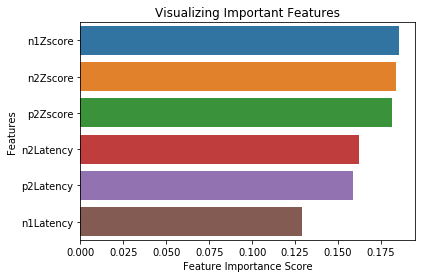

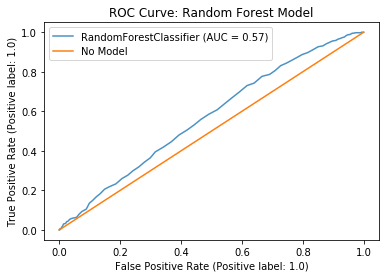

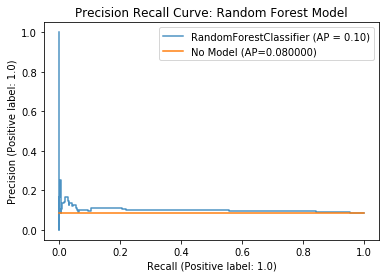

Accuracy: 0.5543945912722803
AUC_ROC = 0.569595
AP_PR =0.101177


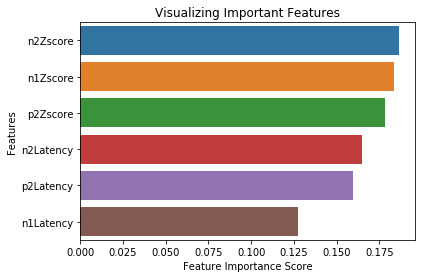

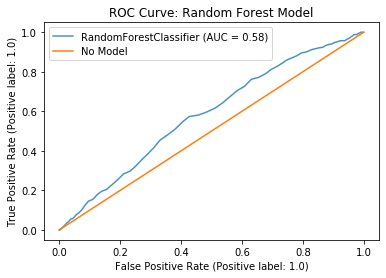

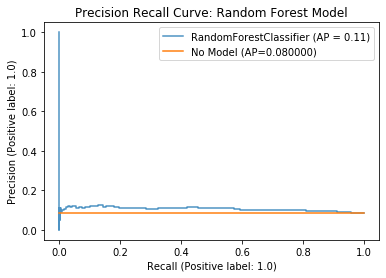

Accuracy: 0.54619954927269
AUC_ROC = 0.583278
AP_PR =0.106643


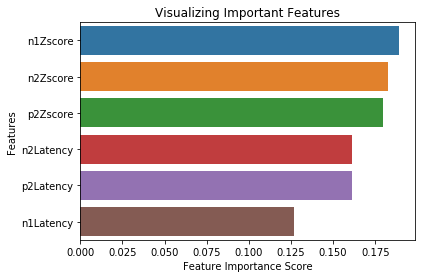

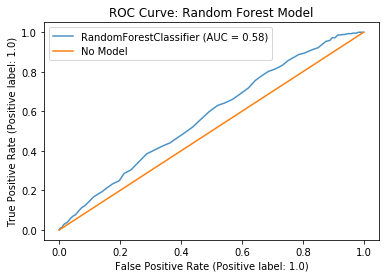

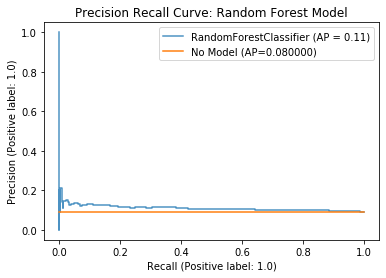

Accuracy: 0.5394386396230281
AUC_ROC = 0.575972
AP_PR =0.110404


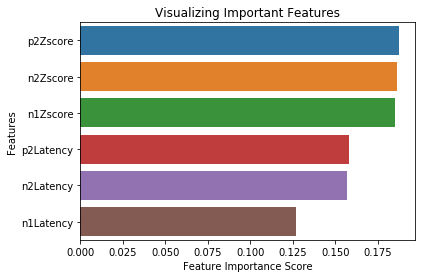

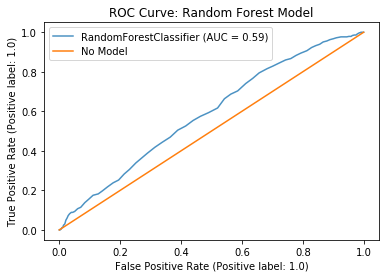

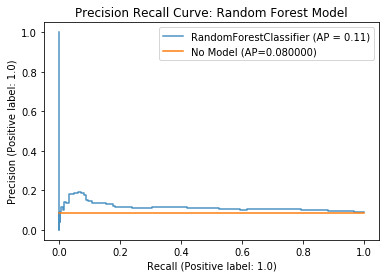

Accuracy: 0.5597213685720139
AUC_ROC = 0.587408
AP_PR =0.114046


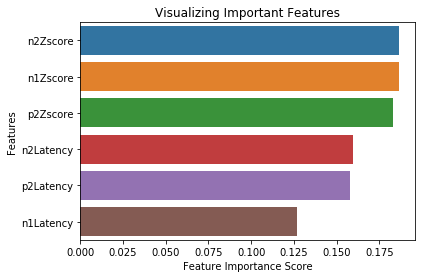

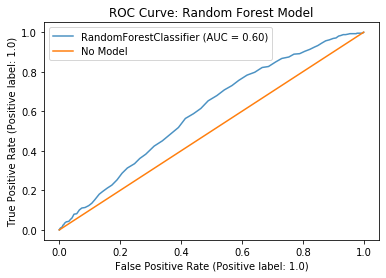

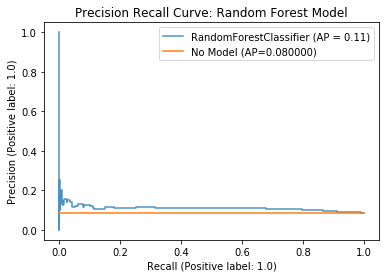

Accuracy: 0.5615652530219217
AUC_ROC = 0.599820
AP_PR =0.110143


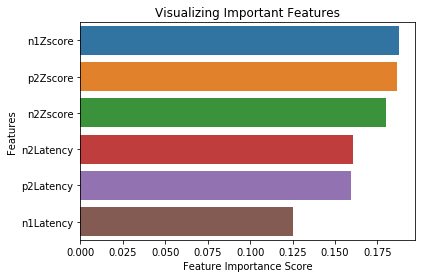

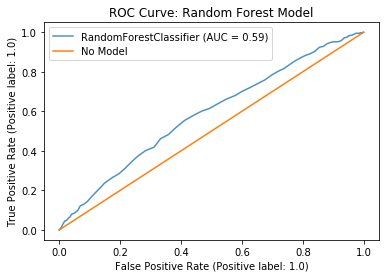

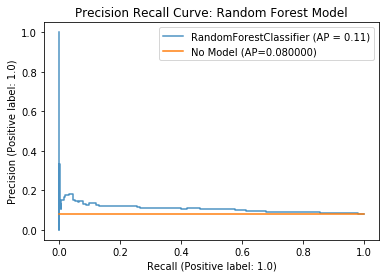

Accuracy: 0.5615652530219217
AUC_ROC = 0.585699
AP_PR =0.108138


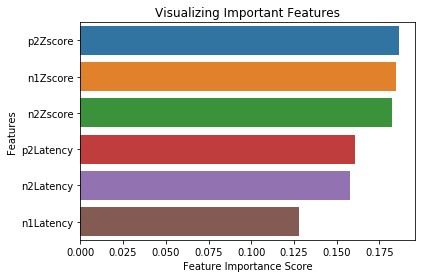

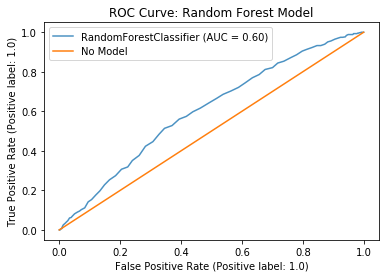

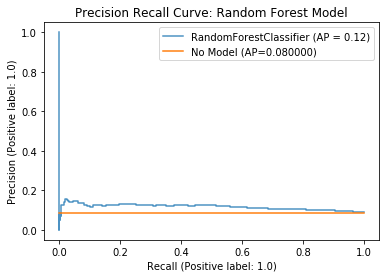

Accuracy: 0.5644335177217783
AUC_ROC = 0.603266
AP_PR =0.116465


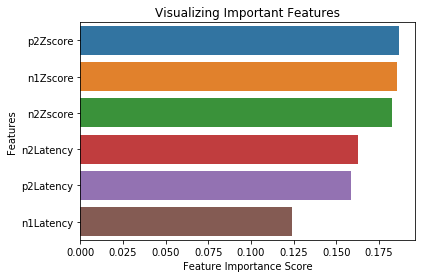

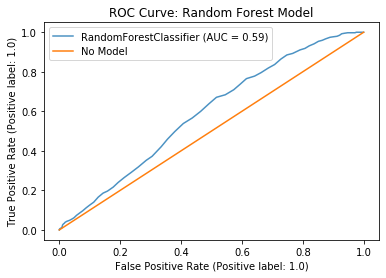

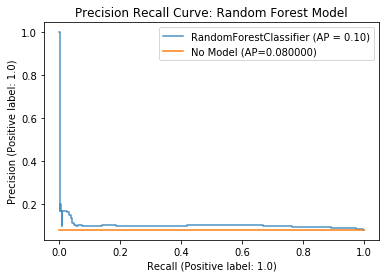

Accuracy: 0.5634091374718295
AUC_ROC = 0.589887
AP_PR =0.102606


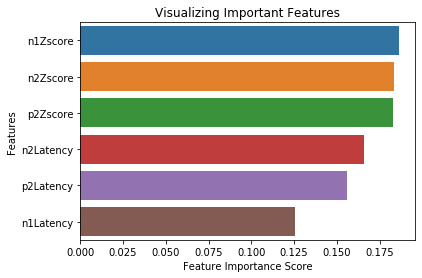

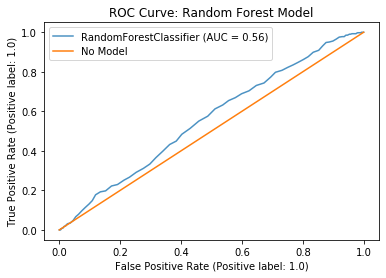

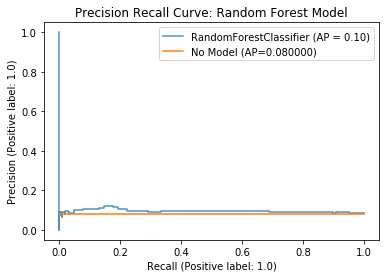

Accuracy: 0.5654578979717271
AUC_ROC = 0.558761
AP_PR =0.095865


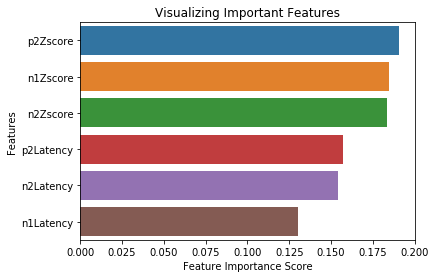

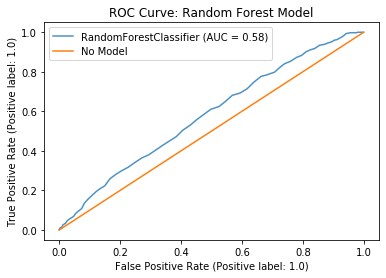

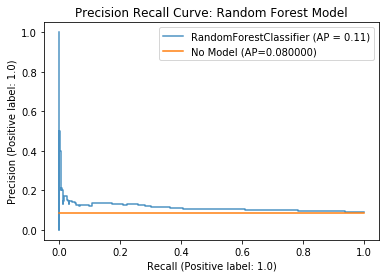

Accuracy: 0.548658061872567
AUC_ROC = 0.581123
AP_PR =0.113601


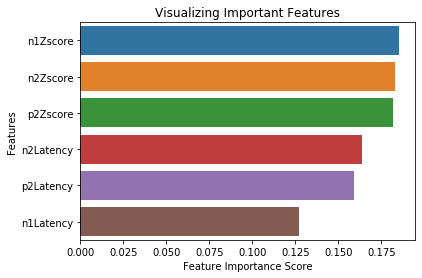

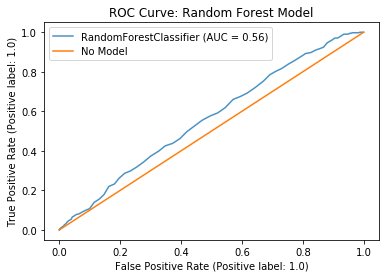

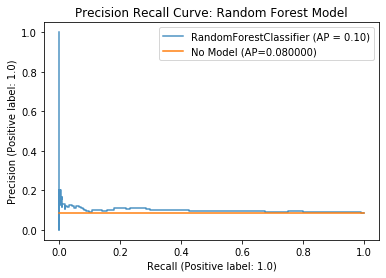

Accuracy: 0.5517312026224135
AUC_ROC = 0.562369
AP_PR =0.099553


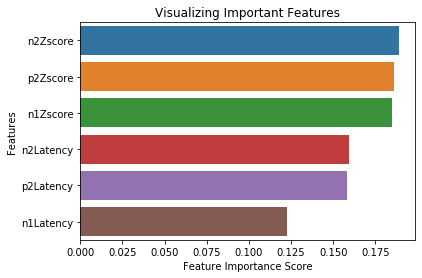

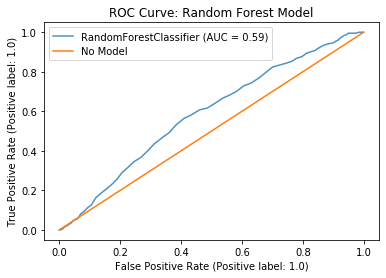

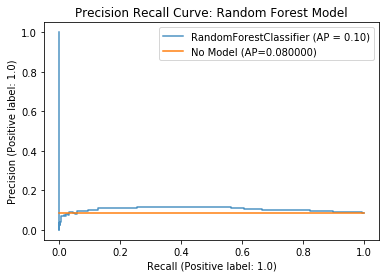

Accuracy: 0.5449702929727515
AUC_ROC = 0.587036
AP_PR =0.104582


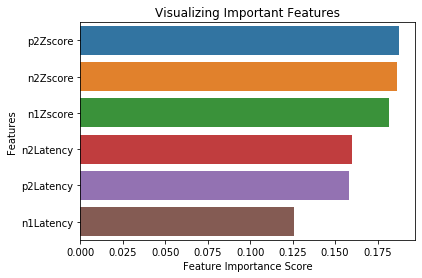

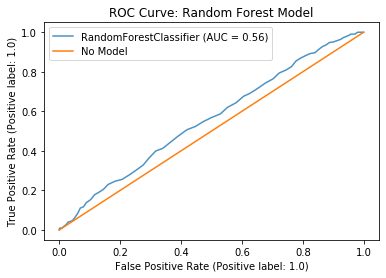

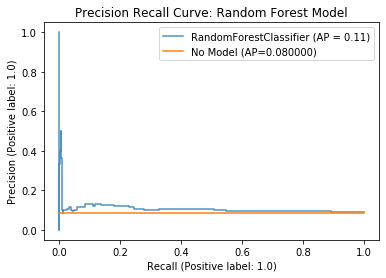

Accuracy: 0.5500921942224954
AUC_ROC = 0.558324
AP_PR =0.106119


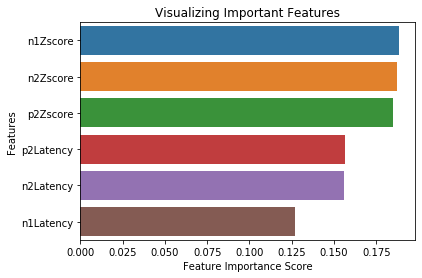

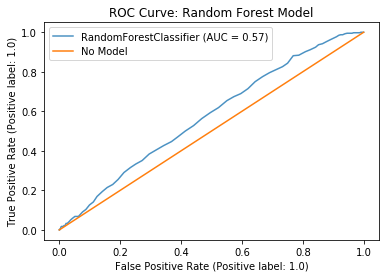

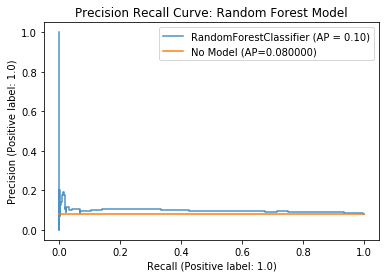

Accuracy: 0.5562384757221881
AUC_ROC = 0.573889
AP_PR =0.098701


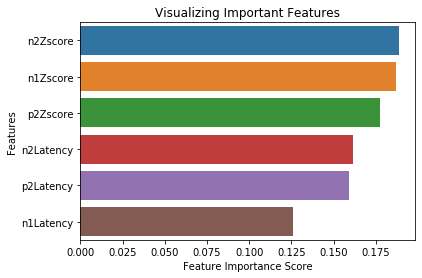

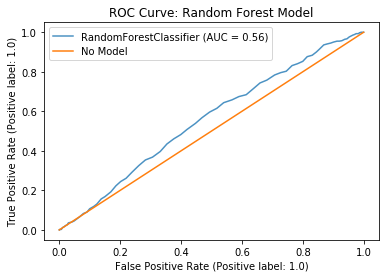

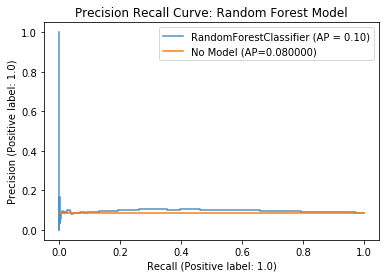

Accuracy: 0.551321450522434
AUC_ROC = 0.556402
AP_PR =0.097303


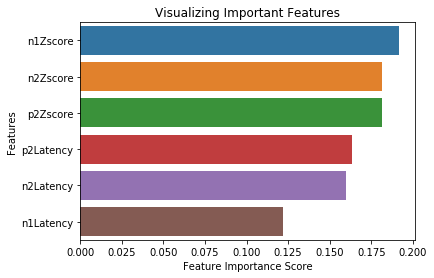

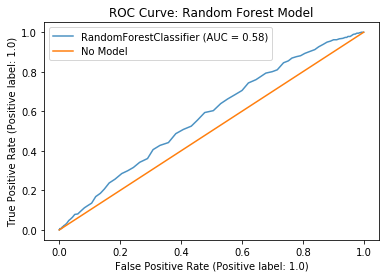

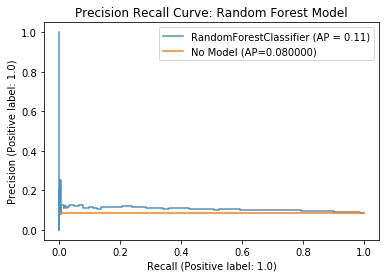

Accuracy: 0.5466093013726695
AUC_ROC = 0.577434
AP_PR =0.106812


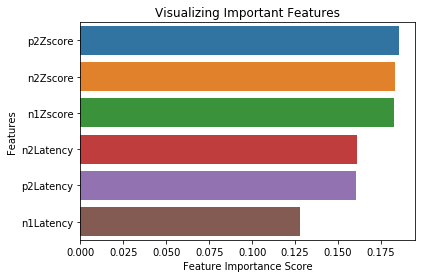

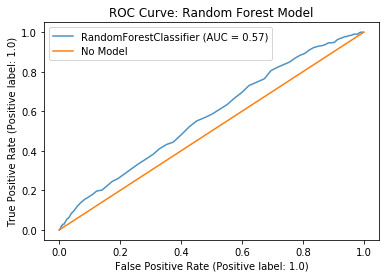

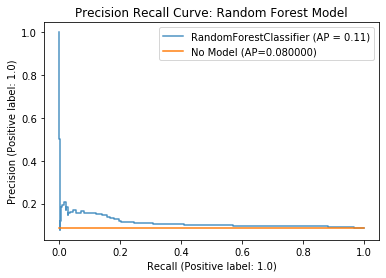

Accuracy: 0.5685310387215734
AUC_ROC = 0.574545
AP_PR =0.111019


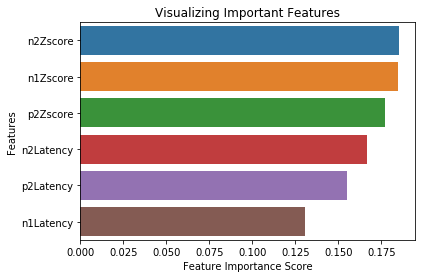

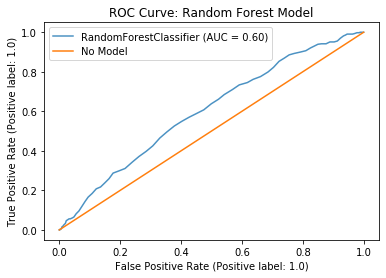

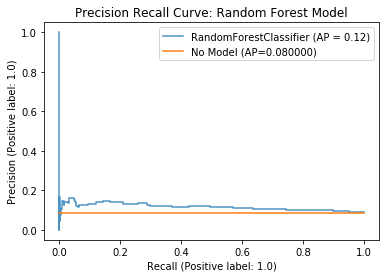

Accuracy: 0.5527555828723623
AUC_ROC = 0.600467
AP_PR =0.116798


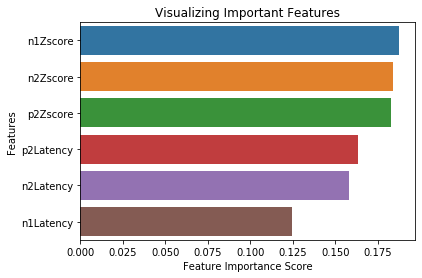

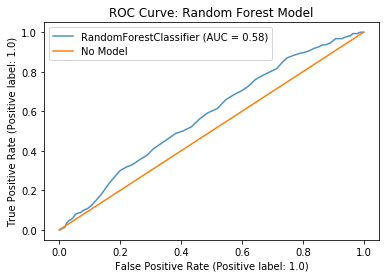

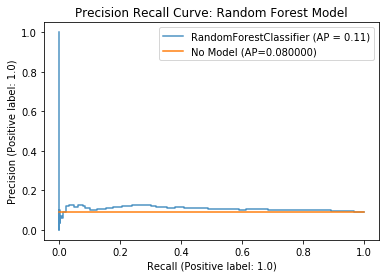

Accuracy: 0.5617701290719115
AUC_ROC = 0.579385
AP_PR =0.108027


In [7]:
Acc = []
AUC = []
AP = []
FI =np.array([0,0,0,0,0,0])

for i in range(50):
    Acc_, AUC_, AP_, FI_ = randomForest(all_positive_patients,keys[2:8],'downsample')
    Acc.append(Acc_)
    AP.append(AP_)
    AUC.append(AUC_)
    FI = FI + np.array(FI_)    

In [ ]:
print('AUC_ROC = %f'%(sum(AUC)/len(AUC)))
print('AP_PR =%f'%(sum(AP)/len(AP)))
print("Accuracy:",sum(Acc)/len(Acc))

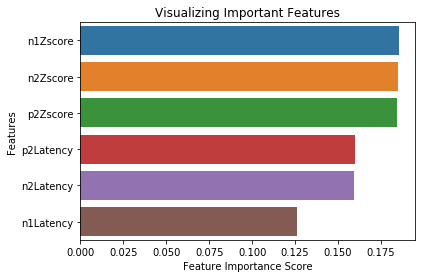

In [61]:
feature_imp = pd.Series(FI/50,index=keys[2:8]).sort_values(ascending=False)
#print(feature_imp)
#plot the feature importance
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('RF Feature Importance.png')
plt.show()

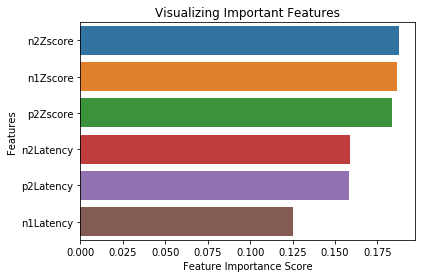

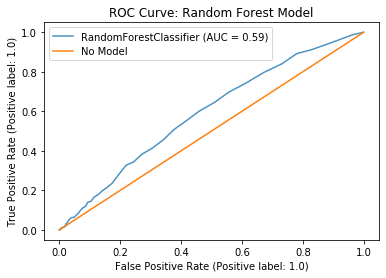

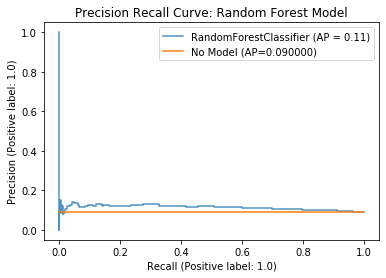

Accuracy: 0.9030936283548453
AUC_ROC = 0.591710
AP_PR =0.114558


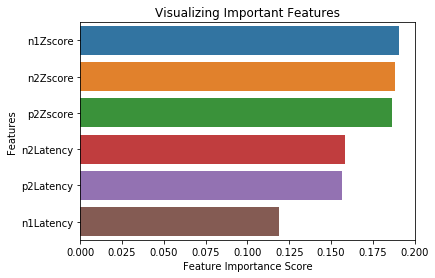

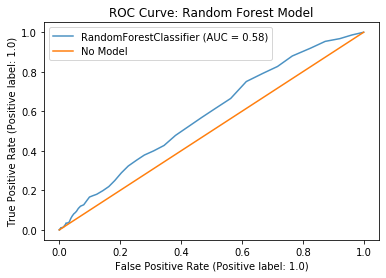

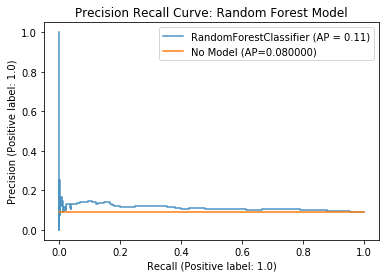

Accuracy: 0.9078057775046097
AUC_ROC = 0.583790
AP_PR =0.112365


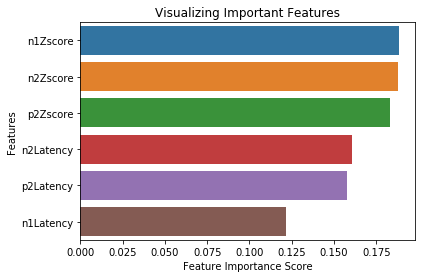

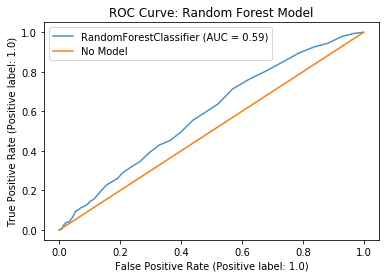

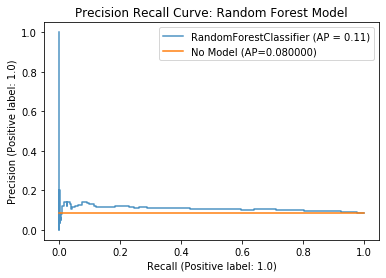

Accuracy: 0.9102642901044868
AUC_ROC = 0.586697
AP_PR =0.107666


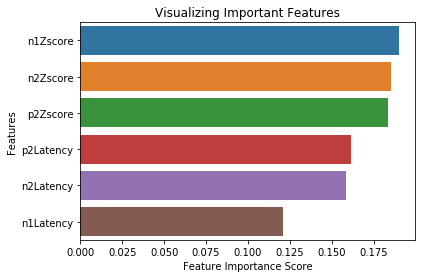

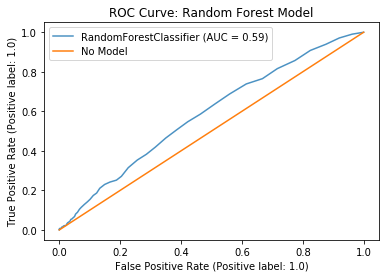

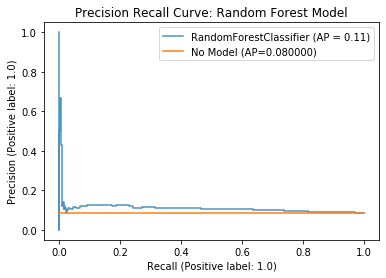

Accuracy: 0.9104691661544766
AUC_ROC = 0.585249
AP_PR =0.109596


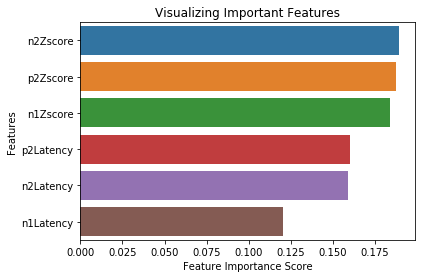

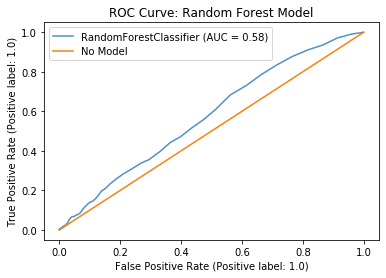

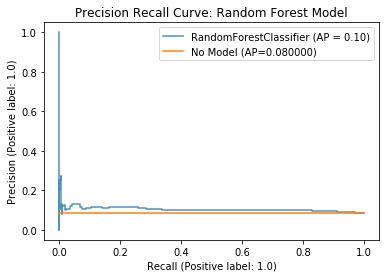

Accuracy: 0.9108789182544561
AUC_ROC = 0.575393
AP_PR =0.104377


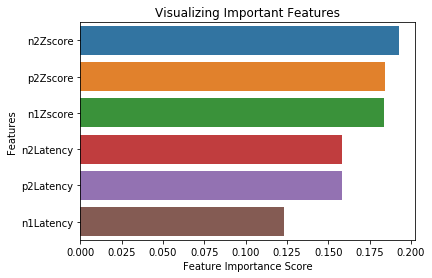

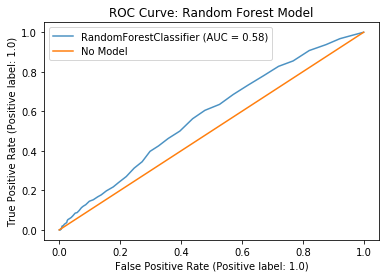

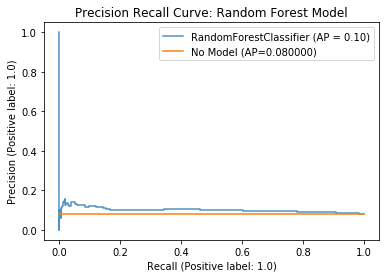

Accuracy: 0.9123130506043844
AUC_ROC = 0.577863
AP_PR =0.101388


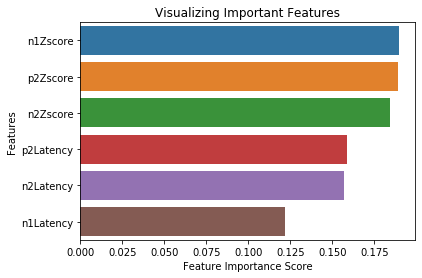

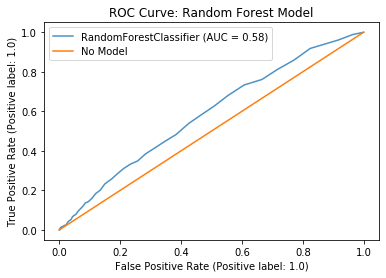

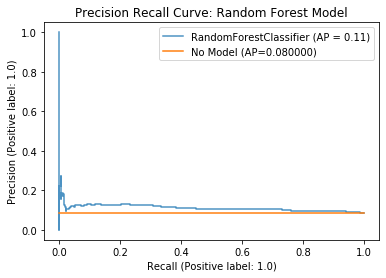

Accuracy: 0.9098545380045072
AUC_ROC = 0.584171
AP_PR =0.111640


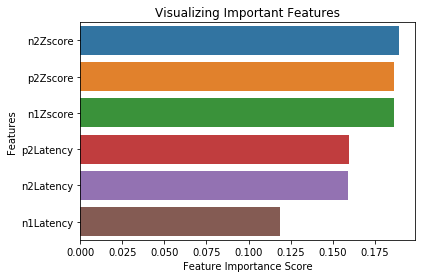

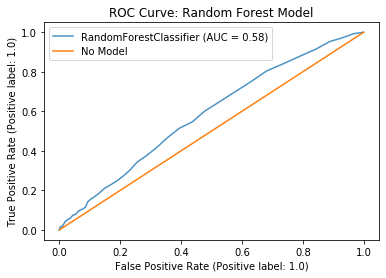

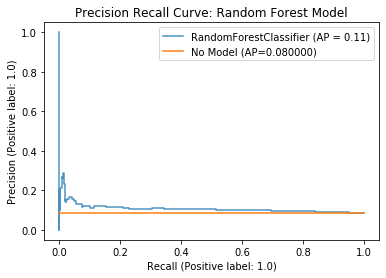

Accuracy: 0.9121081745543946
AUC_ROC = 0.583420
AP_PR =0.107655


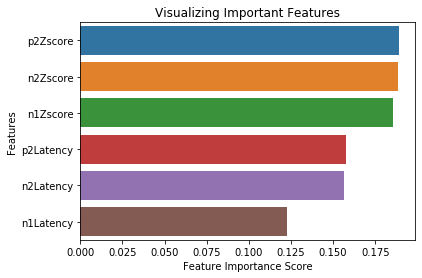

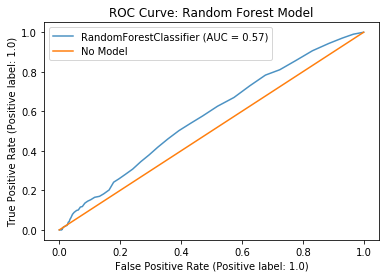

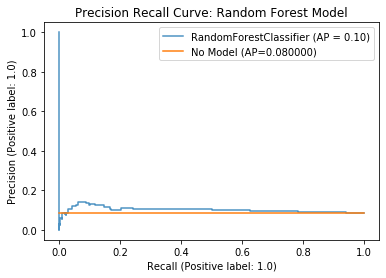

Accuracy: 0.9090350338045482
AUC_ROC = 0.574010
AP_PR =0.101505


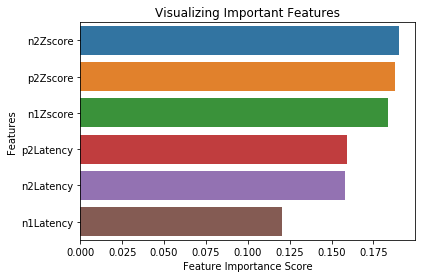

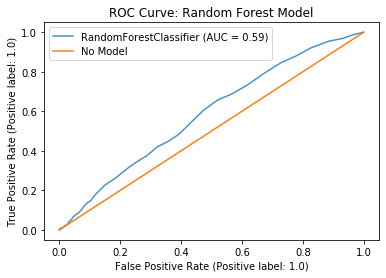

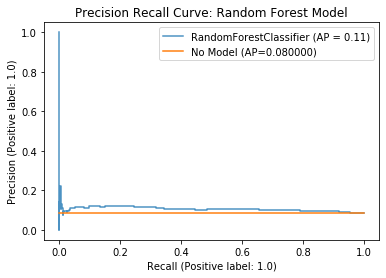

Accuracy: 0.9104691661544766
AUC_ROC = 0.585558
AP_PR =0.105880


In [62]:
Acc = []
AUC = []
AP = []
FI =np.array([0,0,0,0,0,0])

for i in range(10):
    Acc_, AUC_, AP_, FI_ = randomForest(all_positive_patients,keys[2:8],'upsample')
    Acc.append(Acc_)
    AP.append(AP_)
    AUC.append(AUC_)
    FI = FI + np.array(FI_)    

AUC_ROC = 0.583539
AP_PR =0.108197
Accuracy: 0.5548207334562589


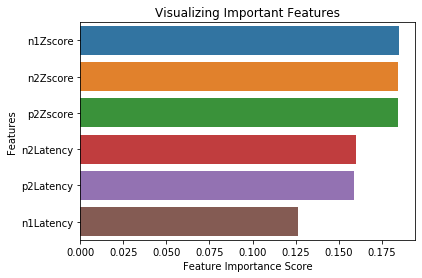

In [8]:
print('AUC_ROC = %f'%(sum(AUC)/len(AUC)))
print('AP_PR =%f'%(sum(AP)/len(AP)))
print("Accuracy:",sum(Acc)/len(Acc))
feature_imp = pd.Series(FI/50,index=keys[2:8]).sort_values(ascending=False)
#print(feature_imp)
#plot the feature importance
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('RF Feature Importance.png')
plt.show()